# Approximate Inference in probabilistic modeling

## 1. Introduction

Exact inference in probabilistic models is usually not possible, due to intractability of expectations or any other quantity involving integrals which are not analytically computable. Hence, algorithms which are able to perform inference approximately, are widely used. 2 main classes of approximate inference algorithms are Variational Inference (VI) based methods, and Sampling based methods.

In this notebook, emphasis will be on demonstrating the efficiency and usefulness of such approximate inference algorithms for probabilistic modeling tasks. 

## 2. Sampling based methods
### 2.1 Rejection Sampling

The most basic algorithm used to sample from a distribution which is not fully tractable, is **Rejection Sampling**. Consider a probability distribution $p(x) = \frac{\tilde{p}(x)}{Z_p}$, where $Z_p$ is intractable. However, we can evaluate $\tilde{p}(x) \,\, \forall x \, \in \, \text{Support}(\tilde{p}(x))$.
The algorithm is simple : At every iteration $t$, we sample $x^{(t)}$ from a proposal distribution $q(x)$ and $u$ from $U[0, Mq(x)]$, where M is a constant such that $Mq(x) > \tilde{p}(x) \,\, \forall x \, \in \, \text{Support}(\tilde{p}(x))$. The support of the proposal distribution should be atleast the support of $\tilde{p}(x)$. 

If $u \geq \tilde{p}(x)$, we add $x^{(t)}$ to the set of samples, else it is rejected. 

In [128]:
import numpy as np 
from scipy.special import gamma
from scipy.stats import multivariate_normal, norm, uniform
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.style.use('seaborn')

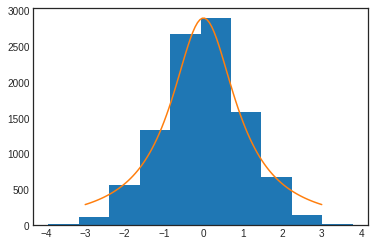

In [386]:
'''1-Dimensional rejection sampling algorithm.
   Try out different p_c (target) distributions and corresponding values of M, q(x)
   to assess convergence time and quality
   Note: Please modify X in plot_histogram as per the distribution being tested
'''

N_SAMPLES = 10000
Q_VAR = 1.0

M = 1

#Cauchy distribution
MU_C, GAMMA = 0, 1

#Normal distribution
MU_N, VAR = 0, 1


def plot_samples(samples, p_c):
    X = np.linspace(-3,3,100)
    p_cX = p_c(X)
    y,_,_ = plt.hist(samples)
    
    C = y.max()/np.max(p_cX)

    plt.plot(X, C*p_cX)
    plt.savefig("sample.png")

def rejection_sampling(p_c, q, M):
    samples = []
    while(len(samples) < N_SAMPLES):
        z = np.random.normal(0.0, np.sqrt(Q_VAR))
        u = np.random.uniform(0.0, M*q(z))
        if u <= p_c(z):
            samples.append(z)
    samples = np.array(samples)

    plot_samples(samples,p_c)

p_cauchy = lambda x: (1/(np.pi * GAMMA)) * ( 1 / ( 1 + ((x-MU_C)/GAMMA) ** 2 ) )
p_normal = lambda x:  (1/np.sqrt(2*np.pi*VAR)) * np.exp(-(1/2*VAR) * (x-MU_N)**2)

q = lambda x: np.exp((-x**2)/(2*Q_VAR)) / np.sqrt(2*np.pi*Q_VAR)

rejection_sampling(p_cauchy, q, M)

In [133]:
'''2-Dimensional rejection sampling algorithm.
   Try out different p_c (target) distributions and corresponding values of M, q(x)
   to assess convergence time and quality
   Note: Please modify X in plot_histogram as per the distribution being tested
'''
N_SAMPLES = 5000
Q_VAR = 2. #Q_COV = Q_VAR * Identity(2x2)

M = 10

#2D Normal
MU_2D = np.array([0.,0.])
COV_2D = np.array([[1.,0.],
                   [0.,1.]])

def plot_samples(samples, p_c):
    x = np.linspace(-5,5,100)
    y = np.linspace(-5,5,100)
    X, Y = np.mgrid[-5:5:0.01,-5:5:0.01]

    XY = np.dstack((X,Y))
    p_cXY = p_c.pdf(XY)
    STEPS = 20
    DELTA = NUM_SAMPLES // STEPS

    for step in range(STEPS):
        plt.contourf(X,Y,p_cXY)
        end = int(step*DELTA)  

        del_samples = samples[:end+1]              
        plt.scatter(*zip(*del_samples))             #Alpha = transparency of scatter plots
        display()
        clear_output(wait=True)
        plt.pause(0.1)

def rejection_sampling(p_c, q, M):
    samples = []
    while len(samples) < N_SAMPLES:
        z = q.rvs()
        u = np.random.uniform(0.0, M*q.pdf(z))
        if u <= p_c.pdf(z):
            samples.append(z)
    samples = np.array(samples)

    plot_samples(samples,p_c)


p_normal_2d = multivariate_normal(MU_2D, COV_2D)
q = multivariate_normal(np.zeros((2,)),Q_VAR*np.identity(2))

rejection_sampling(p_normal_2d, q, M)

TypeError: 'multivariate_normal_frozen' object is not callable

### 2.2 Monte Carlo sampling

This method is used to compute intractable expectations approximately. For commputing expectation of $f(x)$ over a distribution $p(x)$ (which can be sampled from), we have $$E_p[f(x)] = \int f(x) p(x) dx \\
                                E_p[f(x)] \approx \frac{1}{S} \sum_{s=1}^S f(x^{(s)}) \quad ; \quad x^{(s)} \sim p(x)$$

For example, suppose we wish to approximate the expectation $\mathbb{E}_{x \sim p(x)}[e^x], \, \, p(x) = \mathcal{N}(\mu,\sigma^2).$ The actual value calculated using Wolfram-Alpha is $\approx 20.085$ for $\mu=1,\, \sigma^2=4.$

References: CS698X Lectures, Wolfram-Alpha, Scipy.stats.norm documentation

In [31]:
NUM_SAMPLES = 10000
MU, VAR = 1., 4.

def monte_carlo_sampling(f,p):
    result = 0.
    
    samples = p.rvs(size=NUM_SAMPLES)
    for sample in samples:
        result += f(sample)
    
    result *= (1/NUM_SAMPLES)   
    return result

f = lambda x: np.exp(x)
p = norm(loc=MU, scale=np.sqrt(VAR))

print("Expectation: {}".format(monte_carlo_sampling(f,p)))

Expectation: 20.4990171370956


** *Note that Monte Carlo sampling  not  to sample from a probability distribution, but only to compute expectations over a given distribution.* **

The above algorithms are useful till the problems involved are of low-dimension and "simple". As soon as the complexity increases, the above methods fail to provide a solution to the approximate inference problem.

Hence we consider MCMC based sampling algorithms which can generalize well to problems of increased complexity.

### 2.3 Metropolis-Hastings (MH) Algorithm

This is one of the most important MCMC based sampling methods. Here, we sample from the Proposal distribution $q$ which depends on the previous sample $z_{old}$, and accept this new sample $z_{new}$ with an acceptance probability defined by $$A(z_{new},z_{old}) = \text{min}\left(1,\,\frac{p(z_{new}) \cdot q(z_{old} \, | \, z_{new}) }{p(z_{old})\cdot q(z_{new} \, | \, z_{old})}\right)$$ The code below simulates MH Sampling for $p$ a 2D Gaussian with mean MU_MH and covariance COV_MH. Proposal distribution $q(z^{(t)}) = \mathcal{N}(z^{(t)}\, | \,z^{(t-1)},\sigma_0^2\cdot I)$

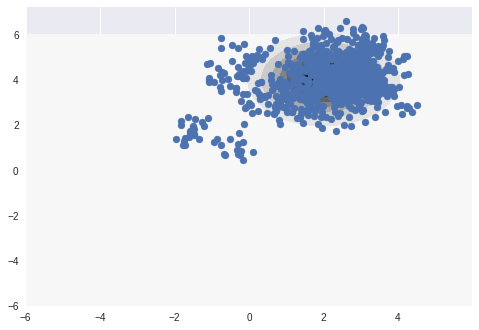

In [135]:
MU_MH = np.array([2.,4.])
COV_MH = np.array([[1,0],[0,1]])

ACCEPT_VAR = 0.1 #Defined as sigma_0 above

NUM_SAMPLES = 1000
BURN_IN = 0
THINNING = 1

def plot_MH_gif(p_c, samples):
    x = np.linspace(-6,6,100)
    y = np.linspace(-6,6,100)
    X, Y = np.mgrid[-6:6:0.01,-6:6:0.01]

    XY = np.dstack((X,Y))
    p_cXY = p_c.pdf(XY)

    STEPS = 20
    DELTA = NUM_SAMPLES // STEPS

    for step in range(STEPS):
        plt.contourf(X,Y,p_cXY)
        end = int(step*DELTA)  

        del_samples = samples[:end+1]              
        plt.scatter(*zip(*del_samples))             #Alpha = transparency of scatter plots
        display()
        clear_output(wait=True)
        plt.pause(0.1)

def metropolis_hastings(p_MH, q):
    samples = []

    z_old = multivariate_normal([0.,0.], np.identity(2)).rvs()  #Randomly choose z_0

    for idx in range(NUM_SAMPLES * THINNING + BURN_IN):
        u = uniform.rvs()
        z_new = multivariate_normal(mean=z_old, cov=ACCEPT_VAR*np.identity(2)).rvs()

        A = 1.
        if (p_MH.pdf(z_old) * q(z_old).pdf(z_new)) > 0:
            A = min(1., (p_MH.pdf(z_new) * q(z_new).pdf(z_old)) / (p_MH.pdf(z_old) * q(z_old).pdf(z_new)) )

        if idx > BURN_IN and (idx-BURN_IN) % THINNING == 0 and A > u:
            samples.append(z_new)
            z_old = z_new
        
    
    plot_MH_gif(p_MH, samples)

p_MH = multivariate_normal(mean=MU_MH, cov=COV_MH)
q = lambda z: multivariate_normal(mean=z, cov=ACCEPT_VAR*np.identity(2)) #Can experiment with other distributions too by modifying this
metropolis_hastings(p_MH,q)

### 2.5 Gibbs Sampling

Often we cannot sample from the joint (multivariate) distribution directly, and must sample one variable at a time, keeping others fixed. To do this Gibbs sampling uses ``Conditional Posteriors'' of variables. These are just the posteriors of one variable calculated while keeping other variables of the distribution fixed. For example in a model $p(z_1,z_2,...,z_M \, | \, X)$ conditional posteriors are given as $p(z_1\,|\,z_2,z_3,...,z_M,X),\, p(z_2\,|\,z_1,z_3,z_4,...,z_M)$ and so on.

Gibbs Sampling is a special case of Metropolis Hastings Algorithm, where the proposal distribution is the required variable's conditional posterior itself, and the Acceptance probability = 1.

Here again we will sample from a 2D Gaussian $p(x,y) = \mathcal{N}(x,y\,|\,\mu_x,\mu_y,\sigma^2_x,\sigma^2_y,\rho_{xy})$ which has a joint pdf given by $$p(x,y) = \frac{1}{2\pi\sigma_x\sigma_y\sqrt{1-\rho_{xy}^2}} \, \exp{\left(\frac{-1}{2(1-\rho_{xy}^2)}\left[\left(\frac{x-\mu_x}{\sigma_x}\right)^2 -2\rho_{xy}\left(\frac{x-\mu_x}{\sigma_x}\right)\left(\frac{y-\mu_y}{\sigma_y}\right)  + \left(\frac{y-\mu_y}{\sigma_y}\right)^2\right]\right)} $$ and conditional posteriors $p(x\,|\,y)$ and $p(y\,|\,x)$ as $$p(x\,|\,y) = \mathcal{N}\left(x\,\middle|\,\mu_x + \rho_{xy}\frac{\sigma_x}{\sigma_y}(y-\mu_y),\sigma_x^2(1-\rho_{xy}^2)\right) \\
p(y\,|\,x) = \mathcal{N}\left(y\,\middle|\,\mu_y + \rho_{xy}\frac{\sigma_y}{\sigma_x}(x-\mu_x),\sigma_y^2(1-\rho_{xy}^2)\right) $$

Hence we can use this information in sampling from $p(x,y).$ 

In [161]:
MU_X = 1.
MU_Y = 2.
SIG_X = 1.
SIG_Y = 1.
RHO = 0.5

NUM_SAMPLES = 1000

def plot_gibbs(p_c, X_samples, Y_samples):
    x = np.linspace(-6,6,100)
    y = np.linspace(-6,6,100)
    X, Y = np.mgrid[-6:6:0.01,-6:6:0.01]

    # XY = np.dstack((X,Y))
    p_cXY = p_c(X.ravel(),Y.ravel())
    p_cxy = p_cXY.reshape(X.shape)
    
    STEPS = NUM_SAMPLES
    DELTA = NUM_SAMPLES // STEPS

    for step in range(STEPS):
        
        end = int(step*DELTA)  

        del_X_samples = X_samples[:end+1]              
        del_Y_samples = Y_samples[:end+1]   
        
        plt.contourf(X,Y,p_cxy)
        plt.scatter(del_X_samples,del_Y_samples)             #Alpha = transparency of scatter plots
        display()
        clear_output(wait=True)
        plt.pause(0.1)


def gibbs_sampling(p_c,num_samples=NUM_SAMPLES):
    X_samples=[]
    Y_samples=[]

    X_old, Y_old = norm.rvs(loc=1.5, scale=1., size=2)

    for step in range(num_samples):
        X = norm.rvs(loc=(MU_X + RHO*(SIG_X/SIG_Y)*(Y_old-MU_Y)), scale=SIG_X*SIG_X*(1-RHO**2))
        Y = Y_old
        
        X_old, Y_old = X, Y
        
        X_samples.append(X)
        Y_samples.append(Y)
        
        X = X_old
        Y = norm.rvs(loc=(MU_Y + RHO*(SIG_Y/SIG_X)*(X-MU_X)), scale=SIG_Y*SIG_Y*(1-RHO**2))

        X_old, Y_old = X, Y

        X_samples.append(X)
        Y_samples.append(Y)

    plot_gibbs(p_c,X_samples,Y_samples)

p_c = lambda x,y: ( 1 / ( 2*np.pi*SIG_X*SIG_Y*np.sqrt(1-RHO**2) ) ) * np.exp( -0.5 * (1/(1-RHO**2)) * ( ((x-MU_X)/SIG_X)**2 - 2*RHO*((x-MU_X)/SIG_X)*((y-MU_Y)/SIG_Y) + ((y-MU_Y)/SIG_Y)**2 ) )

gibbs_sampling(p_c)

KeyboardInterrupt: 

## References
CS698X lectures, Winter 2021

https://www.scipy.org/docs.html (Scipy documentation)

https://matplotlib.org/stable/contents.html (Matplotlib documentation)

https://medium.com/@shahinrostami/jupyter-notebook-and-updating-plots-f1ec4cdc354b (For creating 'animated' plots)
